In [3]:
# 1. Import library
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin
RANDOM_STATE = 42
pd.set_option("display.max_columns", None)

In [4]:
df = pd.read_csv("framingham.csv")

In [6]:
# 3. Pilih 8 fitur utama
selected_features = [
    "male",
    "age",
    "currentSmoker",
    "cigsPerDay",
    "BPMeds",
    "prevalentHyp",
    "diabetes",
    "totChol"
]

In [7]:

target_col = "TenYearCHD"

# Pastikan semua kolom ada
print("Kolom yang digunakan:")
print(selected_features + [target_col])
print(df[selected_features + [target_col]].head())

Kolom yang digunakan:
['male', 'age', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentHyp', 'diabetes', 'totChol', 'TenYearCHD']
   male  age  currentSmoker  cigsPerDay  BPMeds  prevalentHyp  diabetes  \
0     1   39              0         0.0     0.0             0         0   
1     0   46              0         0.0     0.0             0         0   
2     1   48              1        20.0     0.0             0         0   
3     0   61              1        30.0     0.0             1         0   
4     0   46              1        23.0     0.0             0         0   

   totChol  TenYearCHD  
0    195.0           0  
1    250.0           0  
2    245.0           0  
3    225.0           1  
4    285.0           0  


Shape awal: (4240, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   male           4240 non-null   int64  
 1   age            4240 non-null   int64  
 2   currentSmoker  4240 non-null   int64  
 3   cigsPerDay     4211 non-null   float64
 4   BPMeds         4187 non-null   float64
 5   prevalentHyp   4240 non-null   int64  
 6   diabetes       4240 non-null   int64  
 7   totChol        4190 non-null   float64
 8   TenYearCHD     4240 non-null   int64  
dtypes: float64(3), int64(6)
memory usage: 298.3 KB
None
              male          age  currentSmoker   cigsPerDay       BPMeds  \
count  4240.000000  4240.000000    4240.000000  4211.000000  4187.000000   
mean      0.429245    49.580189       0.494104     9.005937     0.029615   
std       0.495027     8.572942       0.500024    11.922462     0.169544   
min       0.000000    32.0

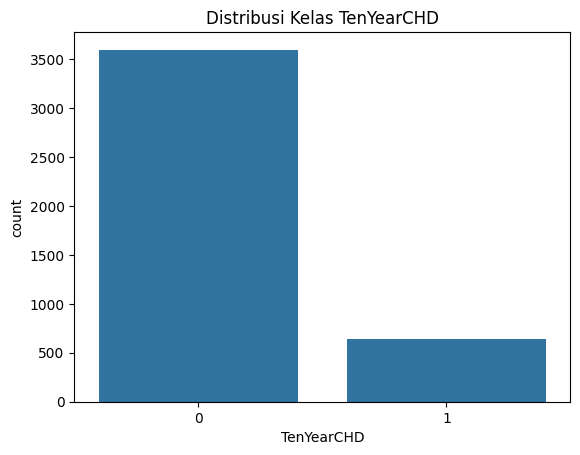

<Figure size 1200x800 with 0 Axes>

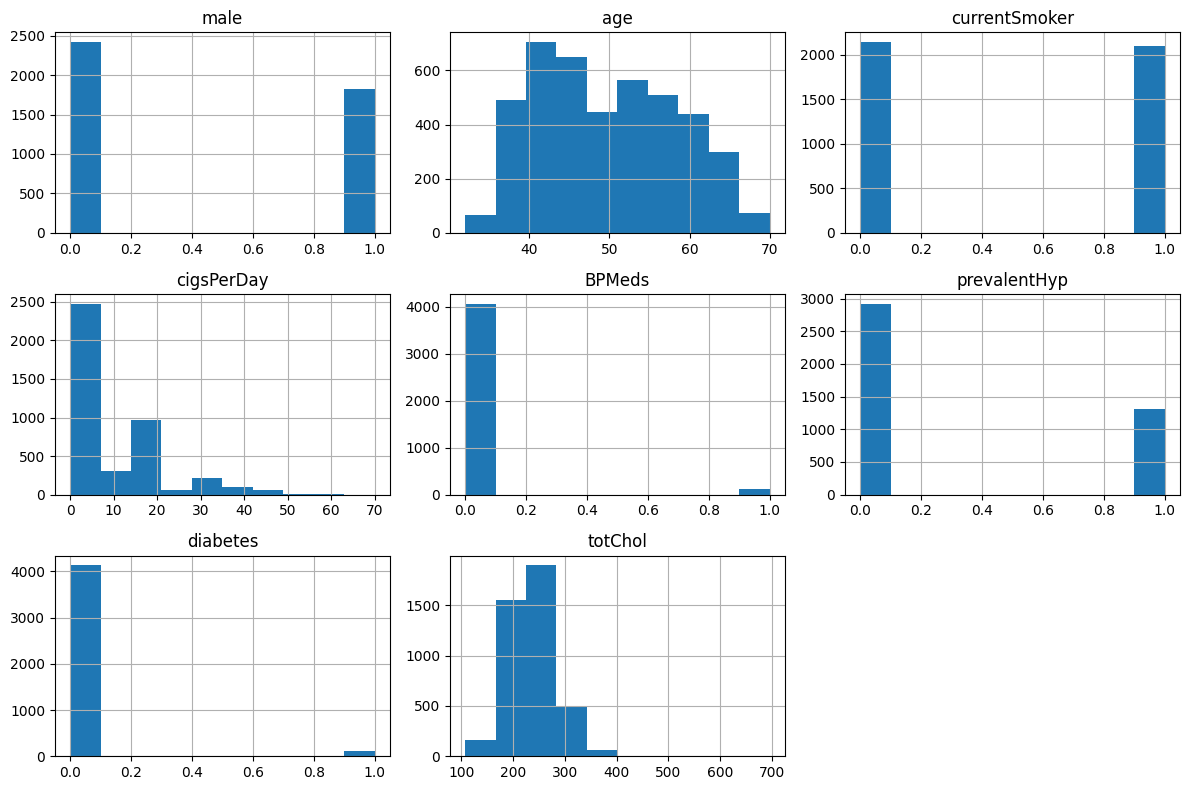

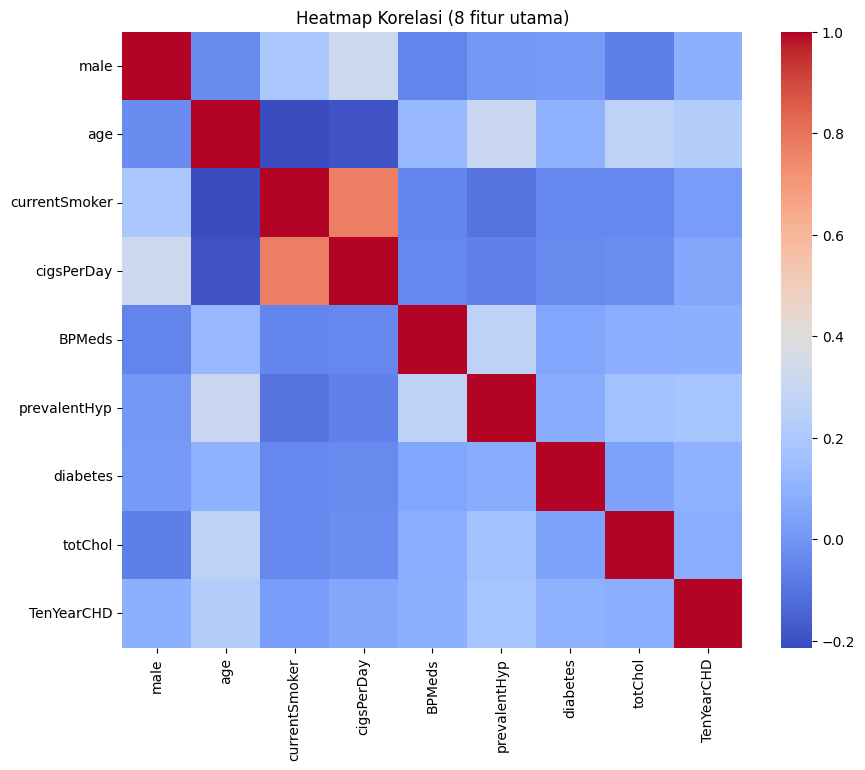

In [8]:
# 4. Explorasi data singkat
print("Shape awal:", df.shape)
print(df[selected_features + [target_col]].info())
print(df[selected_features + [target_col]].describe())

print("\nDistribusi kelas TenYearCHD:")
print(df[target_col].value_counts())
print(df[target_col].value_counts(normalize=True))

plt.figure()
sns.countplot(x=target_col, data=df)
plt.title("Distribusi Kelas TenYearCHD")
plt.show()

plt.figure(figsize=(12, 8))
df[selected_features].hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
corr = df[selected_features + [target_col]].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Heatmap Korelasi (8 fitur utama)")
plt.show()


In [9]:
# 5. Pre-processing

# Imputasi mean untuk missing values di fitur + target (kalau ada)
for col in selected_features + [target_col]:
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].mean())

X = df[selected_features]
y = df[target_col].astype(int)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [10]:
# 6. Split data 80:20 stratified
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

In [11]:

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Distribusi kelas train:")
print(pd.Series(y_train).value_counts(normalize=True))
print("Distribusi kelas test:")
print(pd.Series(y_test).value_counts(normalize=True))

Train shape: (3392, 8) Test shape: (848, 8)
Distribusi kelas train:
TenYearCHD
0    0.848172
1    0.151828
Name: proportion, dtype: float64
Distribusi kelas test:
TenYearCHD
0    0.847877
1    0.152123
Name: proportion, dtype: float64


In [12]:
# 7. Definisi SMOTE-IPF

class SMOTE_IPF(BaseEstimator, TransformerMixin):
    def __init__(self, sampling_strategy=1.0, smote_k=5, ipf_k=3,
                 max_iter=10, random_state=None, verbose=False):
        self.sampling_strategy = sampling_strategy
        self.smote_k = smote_k
        self.ipf_k = ipf_k
        self.max_iter = max_iter
        self.random_state = random_state
        self.verbose = verbose

    def fit(self, X, y=None):
        return self

    def fit_resample(self, X, y):
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y).ravel()

        smote = SMOTE(
            sampling_strategy=self.sampling_strategy,
            k_neighbors=self.smote_k,
            random_state=self.random_state
        )
        X_res, y_res = smote.fit_resample(X, y)

        for it in range(self.max_iter):
            knn = KNeighborsClassifier(n_neighbors=self.ipf_k)
            knn.fit(X_res, y_res)
            y_pred = knn.predict(X_res)

            misclassified = y_pred != y_res
            if not np.any(misclassified):
                if self.verbose:
                    print(f"Iterasi {it+1}: tidak ada noise, berhenti.")
                break

            minority_class = 1 if np.sum(y_res == 1) < np.sum(y_res == 0) else 0
            idx_noise = np.where(misclassified & (y_res == minority_class))[0]

            if len(idx_noise) == 0:
                if self.verbose:
                    print(f"Iterasi {it+1}: tidak ada noise di kelas minoritas, berhenti.")
                break

            if self.verbose:
                print(f"Iterasi {it+1}: menghapus {len(idx_noise)} sampel noise.")

            mask_keep = np.ones(len(X_res), dtype=bool)
            mask_keep[idx_noise] = False
            X_res = X_res[mask_keep]
            y_res = y_res[mask_keep]

        return X_res, y_res

In [13]:
# 8. Fungsi evaluasi

def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n=== {name} ===")
    print("Accuracy :", acc)
    print("Precision:", prec)
    print("Recall   :", rec)
    print("F1-score :", f1)
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    }

results = []

In [18]:
# 9. Skenario 1: Baseline (tanpa oversampling)

svm_baseline = SVC(
    kernel="linear",
    C=1.0,
    random_state=RANDOM_STATE
)
svm_baseline.fit(X_train, y_train)
y_pred_baseline = svm_baseline.predict(X_test)

results.append(evaluate_model("SVM Baseline (Tanpa Oversampling)", y_test, y_pred_baseline))


=== SVM Baseline (Tanpa Oversampling) ===
Accuracy : 0.847877358490566
Precision: 0.0
Recall   : 0.0
F1-score : 0.0

Confusion Matrix:
[[719   0]
 [129   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       719
           1       0.00      0.00      0.00       129

    accuracy                           0.85       848
   macro avg       0.42      0.50      0.46       848
weighted avg       0.72      0.85      0.78       848



In [23]:
# 10. Skenario 2: SMOTE

smote = SMOTE(
    sampling_strategy=0.5,
    random_state=RANDOM_STATE
)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

svm_smote = SVC(
    kernel="linear",
    C=1.0,
    random_state=RANDOM_STATE
)
svm_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = svm_smote.predict(X_test)

results.append(evaluate_model("SVM + SMOTE", y_test, y_pred_smote))


=== SVM + SMOTE ===
Accuracy : 0.8242924528301887
Precision: 0.2826086956521739
Recall   : 0.10077519379844961
F1-score : 0.14857142857142858

Confusion Matrix:
[[686  33]
 [116  13]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       719
           1       0.28      0.10      0.15       129

    accuracy                           0.82       848
   macro avg       0.57      0.53      0.53       848
weighted avg       0.77      0.82      0.79       848



In [28]:
# 11. Skenario 3: SMOTE-IPF

smote_ipf = SMOTE_IPF(
    sampling_strategy=1.0,
    smote_k=5,
    ipf_k=3,
    max_iter=10,
    random_state=RANDOM_STATE,
    verbose=True
)
X_train_smote_ipf, y_train_smote_ipf = smote_ipf.fit_resample(X_train, y_train)

svm_smote_ipf = SVC(
    kernel="linear",
    C=1.0,
    random_state=RANDOM_STATE
)
svm_smote_ipf.fit(X_train_smote_ipf, y_train_smote_ipf)
y_pred_smote_ipf = svm_smote_ipf.predict(X_test)

results.append(evaluate_model("SVM + SMOTE-IPF", y_test, y_pred_smote_ipf))

Iterasi 1: menghapus 451 sampel noise.
Iterasi 2: menghapus 71 sampel noise.
Iterasi 3: menghapus 6 sampel noise.
Iterasi 4: tidak ada noise di kelas minoritas, berhenti.

=== SVM + SMOTE-IPF ===
Accuracy : 0.5966981132075472
Precision: 0.23173803526448364
Recall   : 0.7131782945736435
F1-score : 0.34980988593155893

Confusion Matrix:
[[414 305]
 [ 37  92]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.58      0.71       719
           1       0.23      0.71      0.35       129

    accuracy                           0.60       848
   macro avg       0.57      0.64      0.53       848
weighted avg       0.81      0.60      0.65       848




=== Ringkasan Hasil Semua Skenario ===
                               Model  Accuracy  Precision    Recall  F1-score
0  SVM Baseline (Tanpa Oversampling)  0.634434   0.237681  0.635659  0.345992
1                        SVM + SMOTE  0.633255   0.235465  0.627907  0.342495
2                    SVM + SMOTE-IPF  0.627358   0.236620  0.651163  0.347107


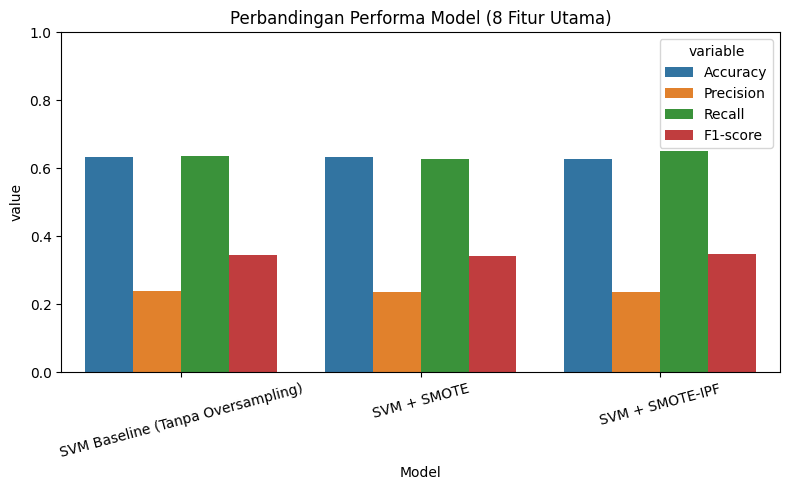

In [17]:

# 12. Ringkasan hasil

results_df = pd.DataFrame(results)
print("\n=== Ringkasan Hasil Semua Skenario ===")
print(results_df)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=results_df.melt(id_vars="Model", value_vars=["Accuracy", "Precision", "Recall", "F1-score"]),
    x="Model", y="value", hue="variable"
)
plt.ylim(0, 1)
plt.title("Perbandingan Performa Model (8 Fitur Utama)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()